In [ ]:
# Cell 1: Import and Setup (LIME Only)
import os
import random
import numpy as np
import keras
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, f1_score
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import KFold
import seaborn as sns
import tensorflow as tf
import pandas as pd
from tensorflow.keras import utils as np_utils

# LIME imports only
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
import warnings
warnings.filterwarnings('ignore')

# Suppress tqdm warning
import os
os.environ['TQDM_DISABLE'] = '1'

d:\Milon\pict\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Cell 2: Data Setup
%matplotlib inline

In [ ]:


root = 'D:/Milon2/SD_81/D3_19/Parietal'
#train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
print(categories)

['D:/Milon2/SD_81/D3_19/Parietal\\Healthy_Control', 'D:/Milon2/SD_81/D3_19/Parietal\\Schizophrenia']


In [ ]:
# Replace the get_image function in Cell 3
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    # Remove preprocess_input for now - we'll handle normalization separately
    # x = preprocess_input(x)  # REMOVE THIS LINE
    return img, x

In [ ]:
# Replace the data loading section in Cell 4
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

num_classes = len(categories)

In [ ]:
# Cell 3: K-Fold Setup
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
fold_no = 1

for train, test in kfold.split(data):
    if os.path.exists(f"D:/Milon2/SD_81/D3_19/LIME/par/train/train{fold_no}.csv") == False:
        np.savetxt(f"D:/Milon2/SD_81/D3_19/LIME/par/train/train{fold_no}.csv", train, delimiter=",", fmt='%s')
        np.savetxt(f"D:/Milon2/SD_81/D3_19/LIME/par/test/test{fold_no}.csv", test, delimiter=",", fmt='%s')
    else:
        print("exists")
    fold_no = fold_no + 1



In [ ]:
# Replace the X, y processing in Cell 6
X, y = np.array([t["x"] for t in data]), np.array([t["y"] for t in data])
# Normalize to [0, 1] range properly
X = X.astype('float32') / 255.0  # This should give us [0, 1] range

In [ ]:
# Cell 4: LIME Functions Only - Fixed Version
def preprocess_for_lime(images):
    """Preprocess images for LIME explanation"""
    processed = []
    for img in images:
        if img.shape == (224, 224, 3):
            img_normalized = img.astype('float32')
            if img_normalized.max() <= 1.0:
                img_normalized = img_normalized * 255.0
            processed.append(img_normalized.astype(np.uint8))
        else:
            processed.append(img)
    return np.array(processed)

def predict_fn(images):
    """Prediction function for LIME"""
    processed_images = []
    for img in images:
        # Ensure image is in [0, 1] range for model prediction
        img_array = img.astype('float32')
        if img_array.max() > 1.0:
            img_array = img_array / 255.0
        img_array = np.clip(img_array, 0, 1)
        processed_images.append(img_array)

    processed_images = np.array(processed_images)
    predictions = model.predict(processed_images, verbose=0)
    return predictions

def explain_with_lime(model, image_data, class_names, num_features=15, num_samples=1500):
    """Generate LIME explanation for a single image"""
    explainer = lime_image.LimeImageExplainer()

    if len(image_data.shape) == 4:
        image_data = image_data[0]

    # Convert to proper format for LIME
    image_data_uint8 = (image_data * 255).astype(np.uint8)

    explanation = explainer.explain_instance(
        image_data_uint8,
        predict_fn,
        top_labels=len(class_names),
        hide_color=0,
        num_samples=num_samples,
        num_features=num_features
    )

    return explanation

def visualize_detailed_lime_explanation(model, image_data, class_names, image_index, true_label, pred_label, pred_probs):
    """Enhanced LIME visualization with detailed segment analysis and external legends"""
    if len(image_data.shape) == 4:
        single_image = image_data[0]
    else:
        single_image = image_data

    original_image = single_image.copy()

    print("Generating detailed LIME explanation...")
    try:
        lime_explanation = explain_with_lime(model, image_data, class_names, num_features=20, num_samples=2000)
        lime_success = True
    except Exception as e:
        print(f"LIME failed: {e}")
        lime_success = False
        return None

    # Fixed the missing variable definition and indentation
    n_cols = len(class_names) * 3 + 2  # original + segmentation + 3 views per class
    total_cols = n_cols // 2 + 1

    # Create figure with proper dimensions
    fig = plt.figure(figsize=(total_cols * (n_cols//2 + 1), 18))  # Fixed indentation and completed the line

    # Create gridspec for better control over layout
    gs = fig.add_gridspec(3, n_cols//2 + 1, height_ratios=[2, 2, 0.5], hspace=0.4, wspace=0.3)

    col_idx = 0
    legend_data = {'positive': {}, 'negative': {}}  # Store legend information

    # Original mel-spectrogram
    ax = fig.add_subplot(gs[0, col_idx])
    ax.imshow(original_image)
    ax.set_title(f'Original Mel-Spectrogram\nIndex: {image_index}\nTrue: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {pred_probs[pred_label]:.3f}',
                 fontsize=12, pad=20)
    ax.axis('off')

    # Add probability text box
    prob_text = '\n'.join([f'{class_names[i]}: {pred_probs[i]:.3f}' for i in range(len(class_names))])
    ax.text(0.02, 0.98, f'Probabilities:\n{prob_text}',
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    col_idx += 1

    # Show all segments with labels
    segments = lime_explanation.segments
    unique_segments = np.unique(segments)

    # Create a colored segment map
    segment_map = np.zeros_like(original_image)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_segments)))

    for i, seg_id in enumerate(unique_segments[:10]):  # Show first 10 segments
        mask = segments == seg_id
        if len(original_image.shape) == 3:
            for c in range(3):
                segment_map[:,:,c][mask] = colors[i][c]
        else:
            segment_map[mask] = colors[i][0]

    ax = fig.add_subplot(gs[0, col_idx])
    ax.imshow(segment_map, alpha=0.7)
    ax.imshow(original_image, alpha=0.3)
    ax.set_title(f'Segmentation Map\n{len(unique_segments)} segments\n(showing first 10)', fontsize=12)
    ax.axis('off')
    col_idx += 1

    # Reset col_idx for second row and ensure we don't exceed grid bounds
    row2_start_col = 0
    current_col = row2_start_col

    # Detailed analysis for each class
    for class_idx, class_name in enumerate(class_names):
        class_explanation = lime_explanation.local_exp[lime_explanation.top_labels[class_idx]]
        positive_features = sorted([f for f in class_explanation if f[1] > 0], key=lambda x: x[1], reverse=True)
        negative_features = sorted([f for f in class_explanation if f[1] < 0], key=lambda x: x[1])

        # Store legend data
        legend_data['positive'][class_name] = positive_features[:5]
        legend_data['negative'][class_name] = negative_features[:5]

        # Positive features only
        if current_col < total_cols:
            ax = fig.add_subplot(gs[1, current_col])
            if positive_features:
                temp_pos, mask_pos = lime_explanation.get_image_and_mask(
                    lime_explanation.top_labels[class_idx],
                    positive_only=True,
                    num_features=len(positive_features),
                    hide_rest=False
                )
                ax.imshow(mark_boundaries(temp_pos / 255.0, mask_pos, color=(0, 1, 0), mode='thick'))
                ax.set_title(f'{class_name}\nPositive Features Only\n({len(positive_features)} segments)', fontsize=12)

                # Add simplified labels without weights (cleaner look)
                for i, (segment_id, weight) in enumerate(positive_features[:5]):
                    segment_mask = (segments == segment_id)
                    if np.any(segment_mask):
                        y_coords, x_coords = np.where(segment_mask)
                        center_y, center_x = np.mean(y_coords), np.mean(x_coords)
                        ax.plot(center_x, center_y, 'go', markersize=15, markeredgewidth=2, markeredgecolor='darkgreen')
                        ax.text(center_x, center_y, f'P{i+1}', color='white', fontweight='bold',
                               ha='center', va='center', fontsize=10)
            else:
                ax.text(0.5, 0.5, f'No positive\nfeatures for\n{class_name}',
                       ha='center', va='center', transform=ax.transAxes,
                       fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgray'))

            ax.axis('off')
            current_col += 1

        # Negative features only
        if current_col < total_cols:
            ax = fig.add_subplot(gs[1, current_col])
            if negative_features:
                temp_neg, mask_neg = lime_explanation.get_image_and_mask(
                    lime_explanation.top_labels[class_idx],
                    positive_only=False,
                    negative_only=True,
                    num_features=len(negative_features),
                    hide_rest=False
                )
                ax.imshow(mark_boundaries(temp_neg / 255.0, mask_neg, color=(1, 0, 0), mode='thick'))
                ax.set_title(f'{class_name}\nNegative Features Only\n({len(negative_features)} segments)', fontsize=12)

                # Add simplified labels without weights
                for i, (segment_id, weight) in enumerate(negative_features[:5]):
                    segment_mask = (segments == segment_id)
                    if np.any(segment_mask):
                        y_coords, x_coords = np.where(segment_mask)
                        center_y, center_x = np.mean(y_coords), np.mean(x_coords)
                        ax.plot(center_x, center_y, 'ro', markersize=15, markeredgewidth=2, markeredgecolor='darkred')
                        ax.text(center_x, center_y, f'N{i+1}', color='white', fontweight='bold',
                               ha='center', va='center', fontsize=10)
            else:
                ax.text(0.5, 0.5, f'No negative\nfeatures for\n{class_name}',
                       ha='center', va='center', transform=ax.transAxes,
                       fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgray'))

            ax.axis('off')
            current_col += 1

        # Combined features with clean labeling
        if current_col < total_cols:
            ax = fig.add_subplot(gs[1, current_col])
            temp_combined, mask_combined = lime_explanation.get_image_and_mask(
                lime_explanation.top_labels[class_idx],
                positive_only=False,
                num_features=15,
                hide_rest=False
            )
            ax.imshow(mark_boundaries(temp_combined / 255.0, mask_combined, color=(1, 1, 0), mode='thick'))
            ax.set_title(f'{class_name}\nCombined Features\nP:{len(positive_features)} N:{len(negative_features)}', fontsize=12)

            # Add clean markers for combined view
            for i, (segment_id, weight) in enumerate(positive_features[:3]):
                segment_mask = (segments == segment_id)
                if np.any(segment_mask):
                    y_coords, x_coords = np.where(segment_mask)
                    center_y, center_x = np.mean(y_coords), np.mean(x_coords)
                    ax.plot(center_x, center_y, 'go', markersize=12, markeredgewidth=2, markeredgecolor='darkgreen')
                    ax.text(center_x, center_y, f'P{i+1}', color='white', fontweight='bold',
                           ha='center', va='center', fontsize=9)

            for i, (segment_id, weight) in enumerate(negative_features[:3]):
                segment_mask = (segments == segment_id)
                if np.any(segment_mask):
                    y_coords, x_coords = np.where(segment_mask)
                    center_y, center_x = np.mean(y_coords), np.mean(x_coords)
                    ax.plot(center_x, center_y, 'ro', markersize=12, markeredgewidth=2, markeredgecolor='darkred')
                    ax.text(center_x, center_y, f'N{i+1}', color='white', fontweight='bold',
                           ha='center', va='center', fontsize=9)

            ax.axis('off')
            current_col += 1

    # Create legend in the bottom section
    legend_ax = fig.add_subplot(gs[2, :])
    legend_ax.axis('off')

    # Create detailed legend text
    legend_text = "LIME SEGMENT EXPLANATIONS:\n\n"
    legend_text += "LEGEND MEANINGS:\n"
    legend_text += "• P1, P2, P3... = Positive contributing segments (support predicted class)\n"
    legend_text += "• N1, N2, N3... = Negative contributing segments (oppose predicted class)\n"
    legend_text += "• Numbers indicate importance ranking (P1 = most important positive)\n\n"

    for class_name in class_names:
        if class_name in legend_data['positive']:
            legend_text += f"--- {class_name.upper()} CLASS ---\n"

            if legend_data['positive'][class_name]:
                legend_text += "TOP POSITIVE SEGMENTS (Support this class):\n"
                for i, (seg_id, weight) in enumerate(legend_data['positive'][class_name]):
                    segment_mask = (segments == seg_id)
                    area = np.sum(segment_mask)
                    percentage = (area / segments.size) * 100
                    legend_text += f"  P{i+1}: Segment {seg_id} | Weight: +{weight:.4f} | Area: {percentage:.1f}%\n"

            if legend_data['negative'][class_name]:
                legend_text += "\nTOP NEGATIVE SEGMENTS (Oppose this class):\n"
                for i, (seg_id, weight) in enumerate(legend_data['negative'][class_name]):
                    segment_mask = (segments == seg_id)
                    area = np.sum(segment_mask)
                    percentage = (area / segments.size) * 100
                    legend_text += f"  N{i+1}: Segment {seg_id} | Weight: {weight:.4f} | Area: {percentage:.1f}%\n"

            legend_text += "\n"

    legend_text += "\nINTERPRETATION:\n"
    legend_text += "• Higher positive weights = stronger support for the class\n"
    legend_text += "• More negative weights = stronger opposition to the class\n"
    legend_text += "• Larger areas = segments cover more of the mel-spectrogram\n"
    legend_text += "• Green markers = Positive contribution, Red markers = Negative contribution"

    legend_ax.text(0.05, 0.95, legend_text, transform=legend_ax.transAxes,
                   fontsize=10, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

    plt.tight_layout()
    return fig, lime_explanation

def analyze_lime_segments(lime_explanation, class_names, segments, original_image):
    """Enhanced detailed analysis of LIME segments with better formatting"""
    print(f"\n{'='*90}")
    print(f"COMPREHENSIVE LIME SEGMENT ANALYSIS")
    print(f"{'='*90}")

    print(f"Total segments identified: {len(np.unique(segments))}")
    print(f"Image dimensions: {original_image.shape}")
    print(f"Total pixels analyzed: {segments.size}")

    for class_idx in lime_explanation.top_labels:
        class_explanation = lime_explanation.local_exp[class_idx]
        positive_features = sorted([f for f in class_explanation if f[1] > 0], key=lambda x: x[1], reverse=True)
        negative_features = sorted([f for f in class_explanation if f[1] < 0], key=lambda x: x[1])

        print(f"\n{'-'*70}")
        print(f"CLASS: {class_names[class_idx].upper()}")
        print(f"{'-'*70}")

        print(f"\n🟢 POSITIVE CONTRIBUTING SEGMENTS: {len(positive_features)}")
        print("   (These segments SUPPORT classification as this class)")
        if positive_features:
            print(f"{'Rank':<6} {'Label':<8} {'Segment ID':<12} {'Weight':<12} {'Area %':<10} {'Interpretation'}")
            print("-" * 70)
            for i, (seg_id, weight) in enumerate(positive_features[:5]):
                segment_mask = (segments == seg_id)
                area = np.sum(segment_mask)
                percentage = (area / segments.size) * 100
                strength = "Very Strong" if weight > 0.1 else "Strong" if weight > 0.05 else "Moderate"
                print(f"P{i+1:<5} {'P'+str(i+1):<8} {seg_id:<12} {weight:<12.4f} {percentage:<10.1f} {strength}")

        print(f"\n🔴 NEGATIVE CONTRIBUTING SEGMENTS: {len(negative_features)}")
        print("   (These segments OPPOSE classification as this class)")
        if negative_features:
            print(f"{'Rank':<6} {'Label':<8} {'Segment ID':<12} {'Weight':<12} {'Area %':<10} {'Interpretation'}")
            print("-" * 70)
            for i, (seg_id, weight) in enumerate(negative_features[:5]):
                segment_mask = (segments == seg_id)
                area = np.sum(segment_mask)
                percentage = (area / segments.size) * 100
                strength = "Very Strong" if abs(weight) > 0.1 else "Strong" if abs(weight) > 0.05 else "Moderate"
                print(f"N{i+1:<5} {'N'+str(i+1):<8} {seg_id:<12} {weight:<12.4f} {percentage:<10.1f} {strength}")

        # Calculate overall contribution
        total_positive = sum(f[1] for f in positive_features)
        total_negative = sum(f[1] for f in negative_features)
        net_contribution = total_positive + total_negative

        print(f"\n📊 OVERALL CONTRIBUTION ANALYSIS for {class_names[class_idx]}:")
        print(f"   • Total positive contribution: {total_positive:+.4f}")
        print(f"   • Total negative contribution: {total_negative:+.4f}")
        print(f"   • Net contribution: {net_contribution:+.4f}")
        print(f"   • Dominant influence: {'✅ Positive' if total_positive > abs(total_negative) else '❌ Negative'}")

        # Provide interpretation
        if net_contribution > 0:
            print(f"   • INTERPRETATION: LIME shows overall SUPPORT for {class_names[class_idx]} classification")
        else:
            print(f"   • INTERPRETATION: LIME shows overall OPPOSITION to {class_names[class_idx]} classification")

    print(f"\n{'='*90}")
    print("LABEL MEANINGS:")
    print("P1, P2, P3... = Most important positive segments (ranked by contribution)")
    print("N1, N2, N3... = Most important negative segments (ranked by contribution)")
    print("Weight = How much this segment contributes (+positive, -negative)")
    print("Area % = What percentage of the mel-spectrogram this segment covers")
    print(f"{'='*90}")

def analyze_most_impactful_segments(lime_explanations_list, class_names):
    """Analyze which segments are most consistently impactful across all explanations"""
    segment_impact_data = {
        'segment_ids': [],
        'total_weights': [],
        'appearance_counts': [],
        'avg_weights': [],
        'avg_areas': [],
        'impact_types': [],  # 'positive', 'negative', or 'mixed'
        'class_associations': []
    }

    all_segment_data = {}  # segment_id: {'weights': [], 'areas': [], 'classes': []}

    for explanation_data in lime_explanations_list:
        lime_explanation = explanation_data['lime_explanation']
        segments = lime_explanation.segments

        for class_idx in lime_explanation.top_labels:
            class_explanation = lime_explanation.local_exp[class_idx]

            for seg_id, weight in class_explanation:
                if seg_id not in all_segment_data:
                    all_segment_data[seg_id] = {'weights': [], 'areas': [], 'classes': []}

                all_segment_data[seg_id]['weights'].append(weight)
                all_segment_data[seg_id]['classes'].append(class_names[class_idx])

                # Calculate area
                segment_mask = (segments == seg_id)
                area_percentage = (np.sum(segment_mask) / segments.size) * 100
                all_segment_data[seg_id]['areas'].append(area_percentage)

    # Process the collected data
    for seg_id, data in all_segment_data.items():
        weights = np.array(data['weights'])
        areas = np.array(data['areas'])

        segment_impact_data['segment_ids'].append(seg_id)
        segment_impact_data['total_weights'].append(np.sum(np.abs(weights)))
        segment_impact_data['appearance_counts'].append(len(weights))
        segment_impact_data['avg_weights'].append(np.mean(weights))
        segment_impact_data['avg_areas'].append(np.mean(areas))

        # Determine impact type
        positive_count = np.sum(weights > 0)
        negative_count = np.sum(weights < 0)

        if positive_count > negative_count:
            segment_impact_data['impact_types'].append('positive')
        elif negative_count > positive_count:
            segment_impact_data['impact_types'].append('negative')
        else:
            segment_impact_data['impact_types'].append('mixed')

        # Most associated class
        from collections import Counter
        class_counter = Counter(data['classes'])
        most_common_class = class_counter.most_common(1)[0][0]
        segment_impact_data['class_associations'].append(most_common_class)

    return segment_impact_data

def create_most_impactful_segments_chart(segment_impact_data, class_names):
    """Create visualization for most impactful LIME segments"""
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()

    # Sort by total impact
    sorted_indices = np.argsort(segment_impact_data['total_weights'])[::-1][:15]  # Top 15

    top_segment_ids = [segment_impact_data['segment_ids'][i] for i in sorted_indices]
    top_total_weights = [segment_impact_data['total_weights'][i] for i in sorted_indices]
    top_appearance_counts = [segment_impact_data['appearance_counts'][i] for i in sorted_indices]
    top_avg_weights = [segment_impact_data['avg_weights'][i] for i in sorted_indices]
    top_avg_areas = [segment_impact_data['avg_areas'][i] for i in sorted_indices]
    top_impact_types = [segment_impact_data['impact_types'][i] for i in sorted_indices]
    top_class_associations = [segment_impact_data['class_associations'][i] for i in sorted_indices]

    # Chart 1: Most Impactful Segments by Total Weight
    colors = ['green' if t == 'positive' else 'red' if t == 'negative' else 'orange' for t in top_impact_types]
    bars = axes[0].barh(range(len(top_segment_ids)), top_total_weights, color=colors, alpha=0.7)
    axes[0].set_yticks(range(len(top_segment_ids)))
    axes[0].set_yticklabels([f'Seg {sid}' for sid in top_segment_ids])
    axes[0].set_xlabel('Total Absolute Weight (Impact Strength)')
    axes[0].set_title('🎯 Top 15 Most Impactful LIME Segments\n(Across All Analyzed Images)')
    axes[0].grid(True, alpha=0.3)

    # Add value annotations
    for i, (bar, weight) in enumerate(zip(bars, top_total_weights)):
        axes[0].text(weight + max(top_total_weights) * 0.01, bar.get_y() + bar.get_height()/2,
                    f'{weight:.3f}', va='center', fontweight='bold', fontsize=9)

    # Chart 2: Frequency of Appearance
    axes[1].bar(range(len(top_segment_ids)), top_appearance_counts,
               color='steelblue', alpha=0.7)
    axes[1].set_xticks(range(len(top_segment_ids)))
    axes[1].set_xticklabels([f'S{sid}' for sid in top_segment_ids], rotation=45)
    axes[1].set_ylabel('Frequency of Appearance')
    axes[1].set_title('📊 Segment Appearance Frequency\n(How often each segment appears in explanations)')
    axes[1].grid(True, alpha=0.3)

    # Add value annotations
    for i, count in enumerate(top_appearance_counts):
        axes[1].text(i, count + max(top_appearance_counts) * 0.01, str(count),
                    ha='center', va='bottom', fontweight='bold')

    # Chart 3: Average Weight (Positive vs Negative Impact)
    pos_weights = [w if w > 0 else 0 for w in top_avg_weights]
    neg_weights = [abs(w) if w < 0 else 0 for w in top_avg_weights]

    x = range(len(top_segment_ids))
    axes[2].bar(x, pos_weights, label='Average Positive Impact', color='green', alpha=0.7)
    axes[2].bar(x, [-w for w in neg_weights], label='Average Negative Impact', color='red', alpha=0.7)
    axes[2].set_xticks(x)
    axes[2].set_xticklabels([f'S{sid}' for sid in top_segment_ids], rotation=45)
    axes[2].set_ylabel('Average Weight')
    axes[2].set_title('⚖️ Average Impact Direction\n(Positive = Support, Negative = Oppose)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.5)

    # Chart 4: Segment Coverage (Average Area)
    bars = axes[3].bar(range(len(top_segment_ids)), top_avg_areas,
                      color='purple', alpha=0.7)
    axes[3].set_xticks(range(len(top_segment_ids)))
    axes[3].set_xticklabels([f'S{sid}' for sid in top_segment_ids], rotation=45)
    axes[3].set_ylabel('Average Area Coverage (%)')
    axes[3].set_title('📏 Segment Size Analysis\n(Average % of mel-spectrogram covered)')
    axes[3].grid(True, alpha=0.3)

    # Add value annotations
    for i, (bar, area) in enumerate(zip(bars, top_avg_areas)):
        axes[3].text(bar.get_x() + bar.get_width()/2, area + max(top_avg_areas) * 0.01,
                    f'{area:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

    # Chart 5: Class Association Pie Chart
    class_counts = {}
    for class_name in top_class_associations:
        class_counts[class_name] = class_counts.get(class_name, 0) + 1

    if class_counts:
        wedges, texts, autotexts = axes[4].pie(class_counts.values(),
                                              labels=[f'{k}\n({v} segments)' for k, v in class_counts.items()],
                                              autopct='%1.1f%%',
                                              colors=['lightcoral', 'lightblue', 'lightgreen'][:len(class_counts)],
                                              startangle=90)

        for wedge in wedges:
            wedge.set_alpha(0.8)

        axes[4].set_title('🎭 Class Association of\nTop Impactful Segments')

    # Chart 6: Impact Type Distribution
    impact_type_counts = {'positive': 0, 'negative': 0, 'mixed': 0}
    for impact_type in top_impact_types:
        impact_type_counts[impact_type] += 1

    colors_impact = {'positive': 'green', 'negative': 'red', 'mixed': 'orange'}
    labels_impact = {'positive': f'Positive\n({impact_type_counts["positive"]} segments)',
                    'negative': f'Negative\n({impact_type_counts["negative"]} segments)',
                    'mixed': f'Mixed\n({impact_type_counts["mixed"]} segments)'}

    wedges, texts, autotexts = axes[5].pie([impact_type_counts[k] for k in ['positive', 'negative', 'mixed']],
                                          labels=[labels_impact[k] for k in ['positive', 'negative', 'mixed']],
                                          colors=[colors_impact[k] for k in ['positive', 'negative', 'mixed']],
                                          autopct='%1.1f%%',
                                          startangle=90)

    for wedge in wedges:
        wedge.set_alpha(0.7)

    axes[5].set_title('🔄 Impact Type Distribution\nof Top Segments')

    plt.tight_layout()

    # Print detailed analysis
    print(f"\n{'='*100}")
    print(f"🎯 MOST IMPACTFUL LIME SEGMENTS ANALYSIS")
    print(f"{'='*100}")
    print(f"{'Rank':<6} {'Segment':<10} {'Total Impact':<14} {'Frequency':<12} {'Avg Weight':<12} {'Avg Area %':<12} {'Type':<10} {'Class'}")
    print("-" * 100)

    for i in range(min(10, len(top_segment_ids))):  # Top 10
        print(f"{i+1:<6} {f'S{top_segment_ids[i]}':<10} {top_total_weights[i]:<14.4f} "
              f"{top_appearance_counts[i]:<12} {top_avg_weights[i]:<12.4f} "
              f"{top_avg_areas[i]:<12.1f} {top_impact_types[i]:<10} {top_class_associations[i]}")

    print(f"\n📋 KEY INSIGHTS:")
    print(f"• Most impactful segment: S{top_segment_ids[0]} (total impact: {top_total_weights[0]:.4f})")
    print(f"• Most frequent segment: S{top_segment_ids[np.argmax(top_appearance_counts)]} (appears {max(top_appearance_counts)} times)")
    print(f"• Largest coverage segment: S{top_segment_ids[np.argmax(top_avg_areas)]} ({max(top_avg_areas):.1f}% average coverage)")
    print(f"• Dominant impact type: {max(impact_type_counts.items(), key=lambda x: x[1])[0]} ({max(impact_type_counts.values())} segments)")

    return fig

def create_lime_summary_visualization(lime_explanations_data, class_names):
    """Enhanced summary comparison of LIME explanations with better annotations"""
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()

    # Data for plotting
    classes = []
    positive_counts = []
    negative_counts = []
    net_contributions = []

    for data in lime_explanations_data:
        classes.append(f"{data['class_name']}\n(Index: {data['index']})")
        positive_counts.append(data['positive_count'])
        negative_counts.append(data['negative_count'])
        net_contributions.append(data['net_contribution'])

    # Plot 1: Positive vs Negative segments with annotations
    x = np.arange(len(classes))
    width = 0.35

    bars1 = axes[0].bar(x - width/2, positive_counts, width, label='Positive Segments (P1, P2...)', color='green', alpha=0.7)
    bars2 = axes[0].bar(x + width/2, negative_counts, width, label='Negative Segments (N1, N2...)', color='red', alpha=0.7)

    # Add value annotations on bars
    for bar in bars1:
        height = bar.get_height()
        if height > 0:
            axes[0].annotate(f'{int(height)}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),  # 3 points vertical offset
                           textcoords="offset points",
                           ha='center', va='bottom', fontweight='bold')

    for bar in bars2:
        height = bar.get_height()
        if height > 0:
            axes[0].annotate(f'{int(height)}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),  # 3 points vertical offset
                           textcoords="offset points",
                           ha='center', va='bottom', fontweight='bold')

    axes[0].set_xlabel('Images Analyzed')
    axes[0].set_ylabel('Number of Contributing Segments')
    axes[0].set_title('LIME Explanation: Positive vs Negative Contributing Segments\n(P1,P2... = Support class | N1,N2... = Oppose class)')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(classes, rotation=0, ha='center')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Net contributions with enhanced annotations
    colors = ['darkgreen' if x > 0 else 'darkred' for x in net_contributions]
    bars = axes[1].bar(classes, net_contributions, color=colors, alpha=0.7)

    # Add value annotations and interpretation
    for i, (bar, contrib) in enumerate(zip(bars, net_contributions)):
        height = bar.get_height()
        axes[1].annotate(f'{contrib:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3 if height > 0 else -15),
                        textcoords="offset points",
                        ha='center', va='bottom' if height > 0 else 'top',
                        fontweight='bold', color='white',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[i], alpha=0.8))

    axes[1].set_xlabel('Images Analyzed')
    axes[1].set_ylabel('Net LIME Contribution Score')
    axes[1].set_title('Net LIME Contribution per Image\n(Positive = Overall support | Negative = Overall opposition)')
    axes[1].tick_params(axis='x', rotation=0)
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)

    # Plot 3: Segment distribution with detailed labels
    all_positive = sum(positive_counts)
    all_negative = sum(negative_counts)

    wedges, texts, autotexts = axes[2].pie([all_positive, all_negative],
                                          labels=[f'Positive Segments\n(P1,P2,P3...)\n{all_positive} total',
                                                 f'Negative Segments\n(N1,N2,N3...)\n{all_negative} total'],
                                          colors=['green', 'red'],
                                          autopct='%1.1f%%',
                                          startangle=90,
                                          textprops={'fontsize': 11, 'fontweight': 'bold'})

    # Apply alpha to wedges manually
    for wedge in wedges:
        wedge.set_alpha(0.7)

    axes[2].set_title('Overall Distribution of LIME Segments\nAcross All Analyzed Images')

    # Plot 4: Enhanced text summary with legend
    axes[3].axis('off')
    summary_text = "🔍 COMPREHENSIVE LIME ANALYSIS SUMMARY\n\n"
    summary_text += "📋 SEGMENT LABEL MEANINGS:\n"
    summary_text += "• P1, P2, P3... = Positive segments (support the prediction)\n"
    summary_text += "• N1, N2, N3... = Negative segments (oppose the prediction)\n"
    summary_text += "• Numbers indicate importance ranking\n\n"
    summary_text += "📊 ANALYSIS RESULTS:\n"

    for i, data in enumerate(lime_explanations_data):
        accuracy_symbol = "✅" if data['correct'] else "❌"
        contribution_trend = "📈" if data['net_contribution'] > 0 else "📉"

        summary_text += f"\n🖼️ Image {i+1}: {data['class_name']}\n"
        summary_text += f"   • True class: {data['true_class']}\n"
        summary_text += f"   • Predicted: {data['pred_class']} (conf: {data['confidence']:.3f})\n"
        summary_text += f"   • Classification: {accuracy_symbol} {'Correct' if data['correct'] else 'Incorrect'}\n"
        summary_text += f"   • Contributing segments: {data['positive_count']} positive + {data['negative_count']} negative\n"
        summary_text += f"   • Net LIME score: {contribution_trend} {data['net_contribution']:.4f}\n"

    summary_text += f"\n🎯 KEY INSIGHTS:\n"
    summary_text += f"• Total images analyzed: {len(lime_explanations_data)}\n"
    summary_text += f"• Total positive segments: {all_positive}\n"
    summary_text += f"• Total negative segments: {all_negative}\n"
    summary_text += f"• Average segments per image: {(all_positive + all_negative) / len(lime_explanations_data):.1f}\n"

    correct_predictions = sum(1 for data in lime_explanations_data if data['correct'])
    summary_text += f"• Classification accuracy: {correct_predictions}/{len(lime_explanations_data)} correct\n"

    axes[3].text(0.05, 0.95, summary_text, transform=axes[3].transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))

    plt.tight_layout()
    return fig


Fold 1 - Training data shape: (6856, 224, 224, 3)
Fold 1 - Test data shape: (762, 224, 224, 3)
Training for fold 1...
Epoch 1/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.5989 - loss: 0.7035
Epoch 1: val_accuracy improved from None to 0.57612, saving model to D:/Milon2/SD_81/D3_19/LIME/par/a/a1.best.keras
215/215 ━━━━━━━━━━━━━━━━━━━━ 44s 195ms/step - accuracy: 0.6034 - loss: 0.6812 - val_accuracy: 0.5761 - val_loss: 0.6812
Epoch 2/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.6103 - loss: 0.6677
Epoch 2: val_accuracy did not improve from 0.57612
215/215 ━━━━━━━━━━━━━━━━━━━━ 43s 199ms/step - accuracy: 0.6084 - loss: 0.6685 - val_accuracy: 0.5761 - val_loss: 0.6772
Epoch 3/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.6083 - loss: 0.6648
Epoch 3: val_accuracy improved from 0.57612 to 0.58793, saving model to D:/Milon2/SD_81/D3_19/LIME/par/a/a1.best.keras
215/215 ━━━━━━━━━━━━━━━━━━━━ 43s 201ms/step - accuracy: 0.6142 - loss: 0.6612 - val_accu

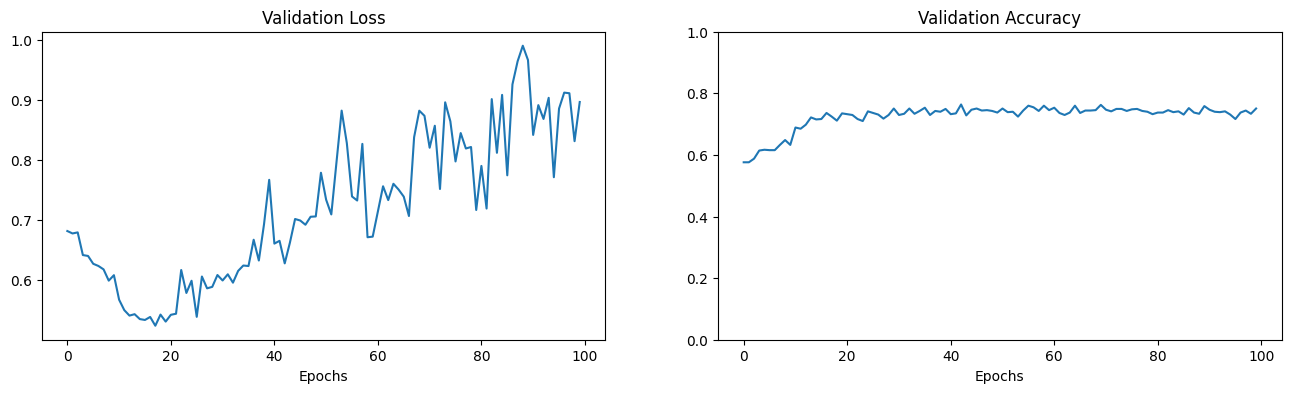

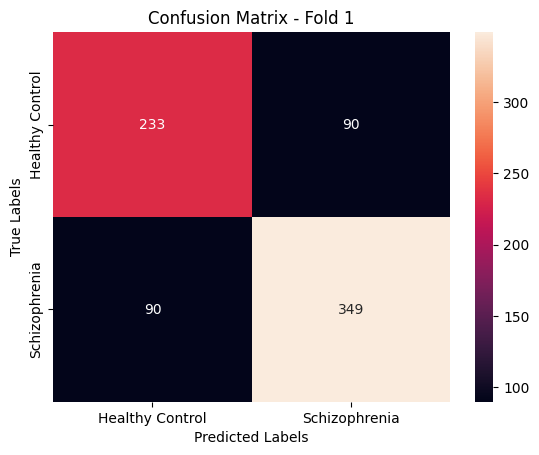


COMPREHENSIVE LIME ANALYSIS FOR SCHIZOPHRENIA CLASSIFICATION
FOLD 1 - MEL-SPECTROGRAM EXPLAINABILITY

DETAILED LIME ANALYSIS: HEALTHY CONTROL
Test Index: 0, Class Label: 0

Image Classification Results:
  • True Label: Healthy Control
  • Predicted Label: Healthy Control
  • Prediction Confidence: 0.7520
  • Classification: ✓ CORRECT
  • Class Probabilities:
    - Healthy Control: 0.7520
    - Schizophrenia: 0.2480
Generating detailed LIME explanation...


100%|██████████| 2000/2000 [00:33<00:00, 59.59it/s]


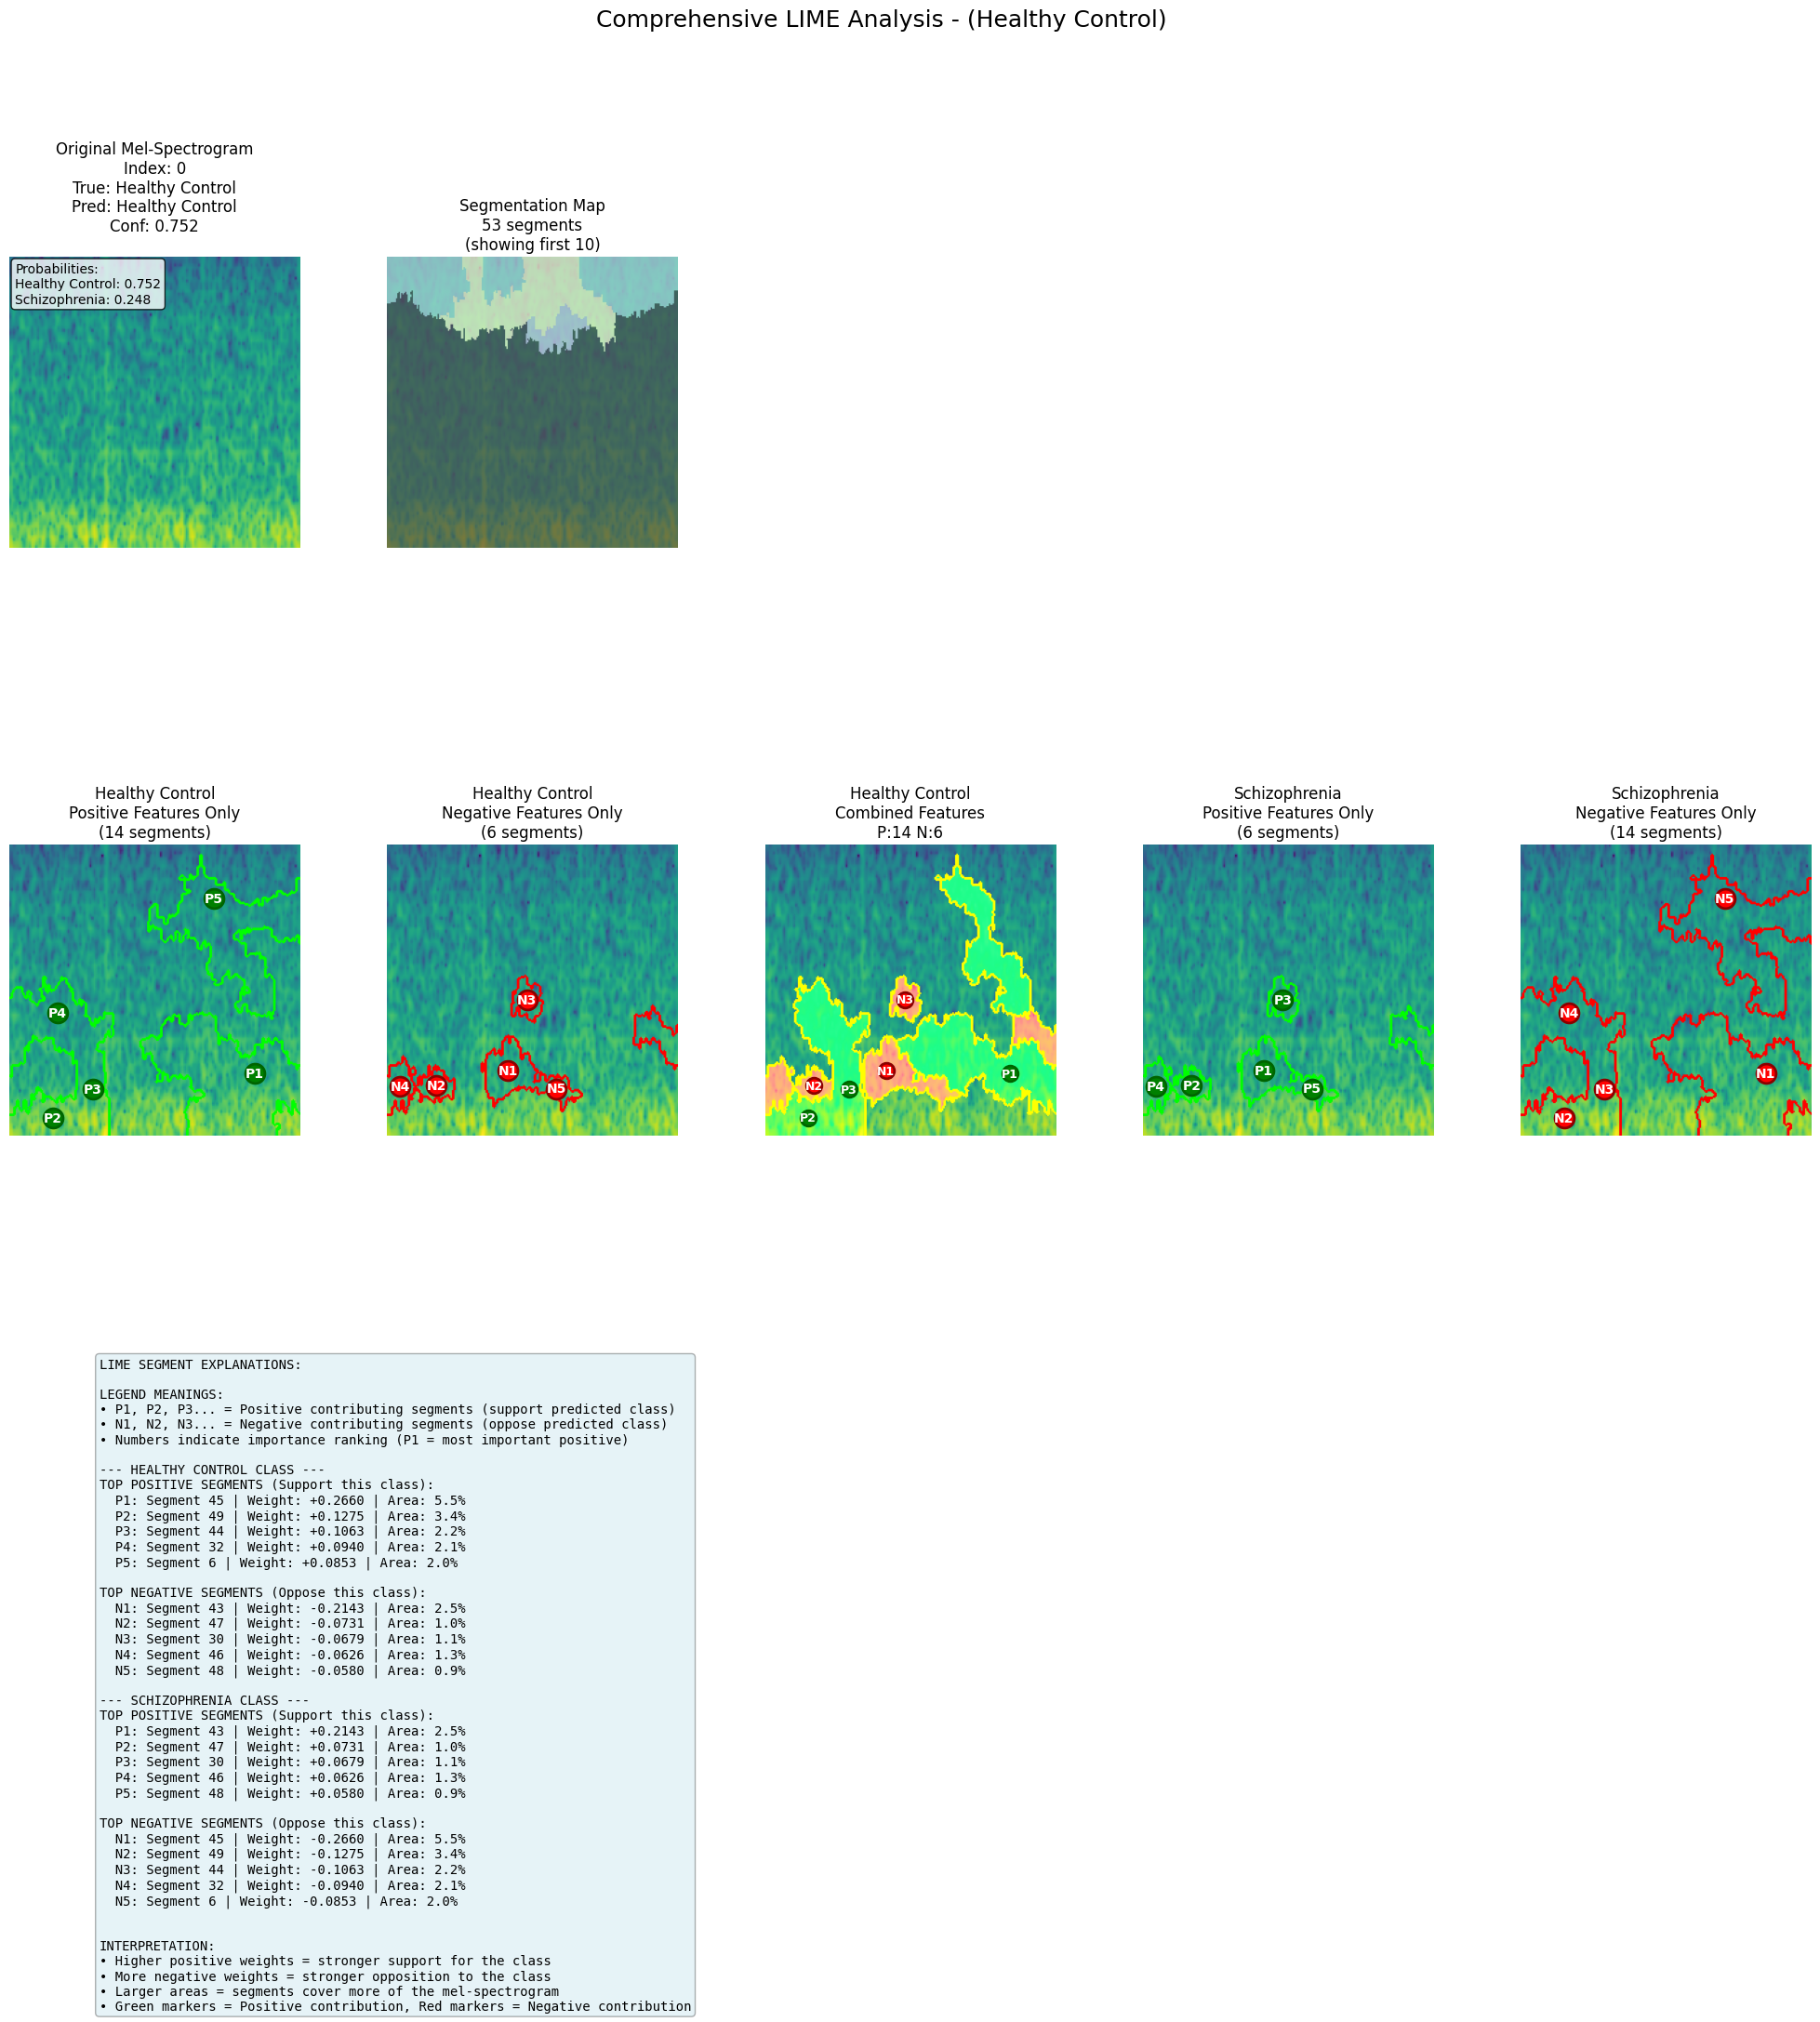


COMPREHENSIVE LIME SEGMENT ANALYSIS
Total segments identified: 53
Image dimensions: (224, 224, 3)
Total pixels analyzed: 50176

----------------------------------------------------------------------
CLASS: HEALTHY CONTROL
----------------------------------------------------------------------

🟢 POSITIVE CONTRIBUTING SEGMENTS: 14
   (These segments SUPPORT classification as this class)
Rank   Label    Segment ID   Weight       Area %     Interpretation
----------------------------------------------------------------------
P1     P1       45           0.2660       5.5        Very Strong
P2     P2       49           0.1275       3.4        Very Strong
P3     P3       44           0.1063       2.2        Very Strong
P4     P4       32           0.0940       2.1        Strong
P5     P5       6            0.0853       2.0        Strong

🔴 NEGATIVE CONTRIBUTING SEGMENTS: 6
   (These segments OPPOSE classification as this class)
Rank   Label    Segment ID   Weight       Area %     Interpretat

100%|██████████| 2000/2000 [00:33<00:00, 59.60it/s]


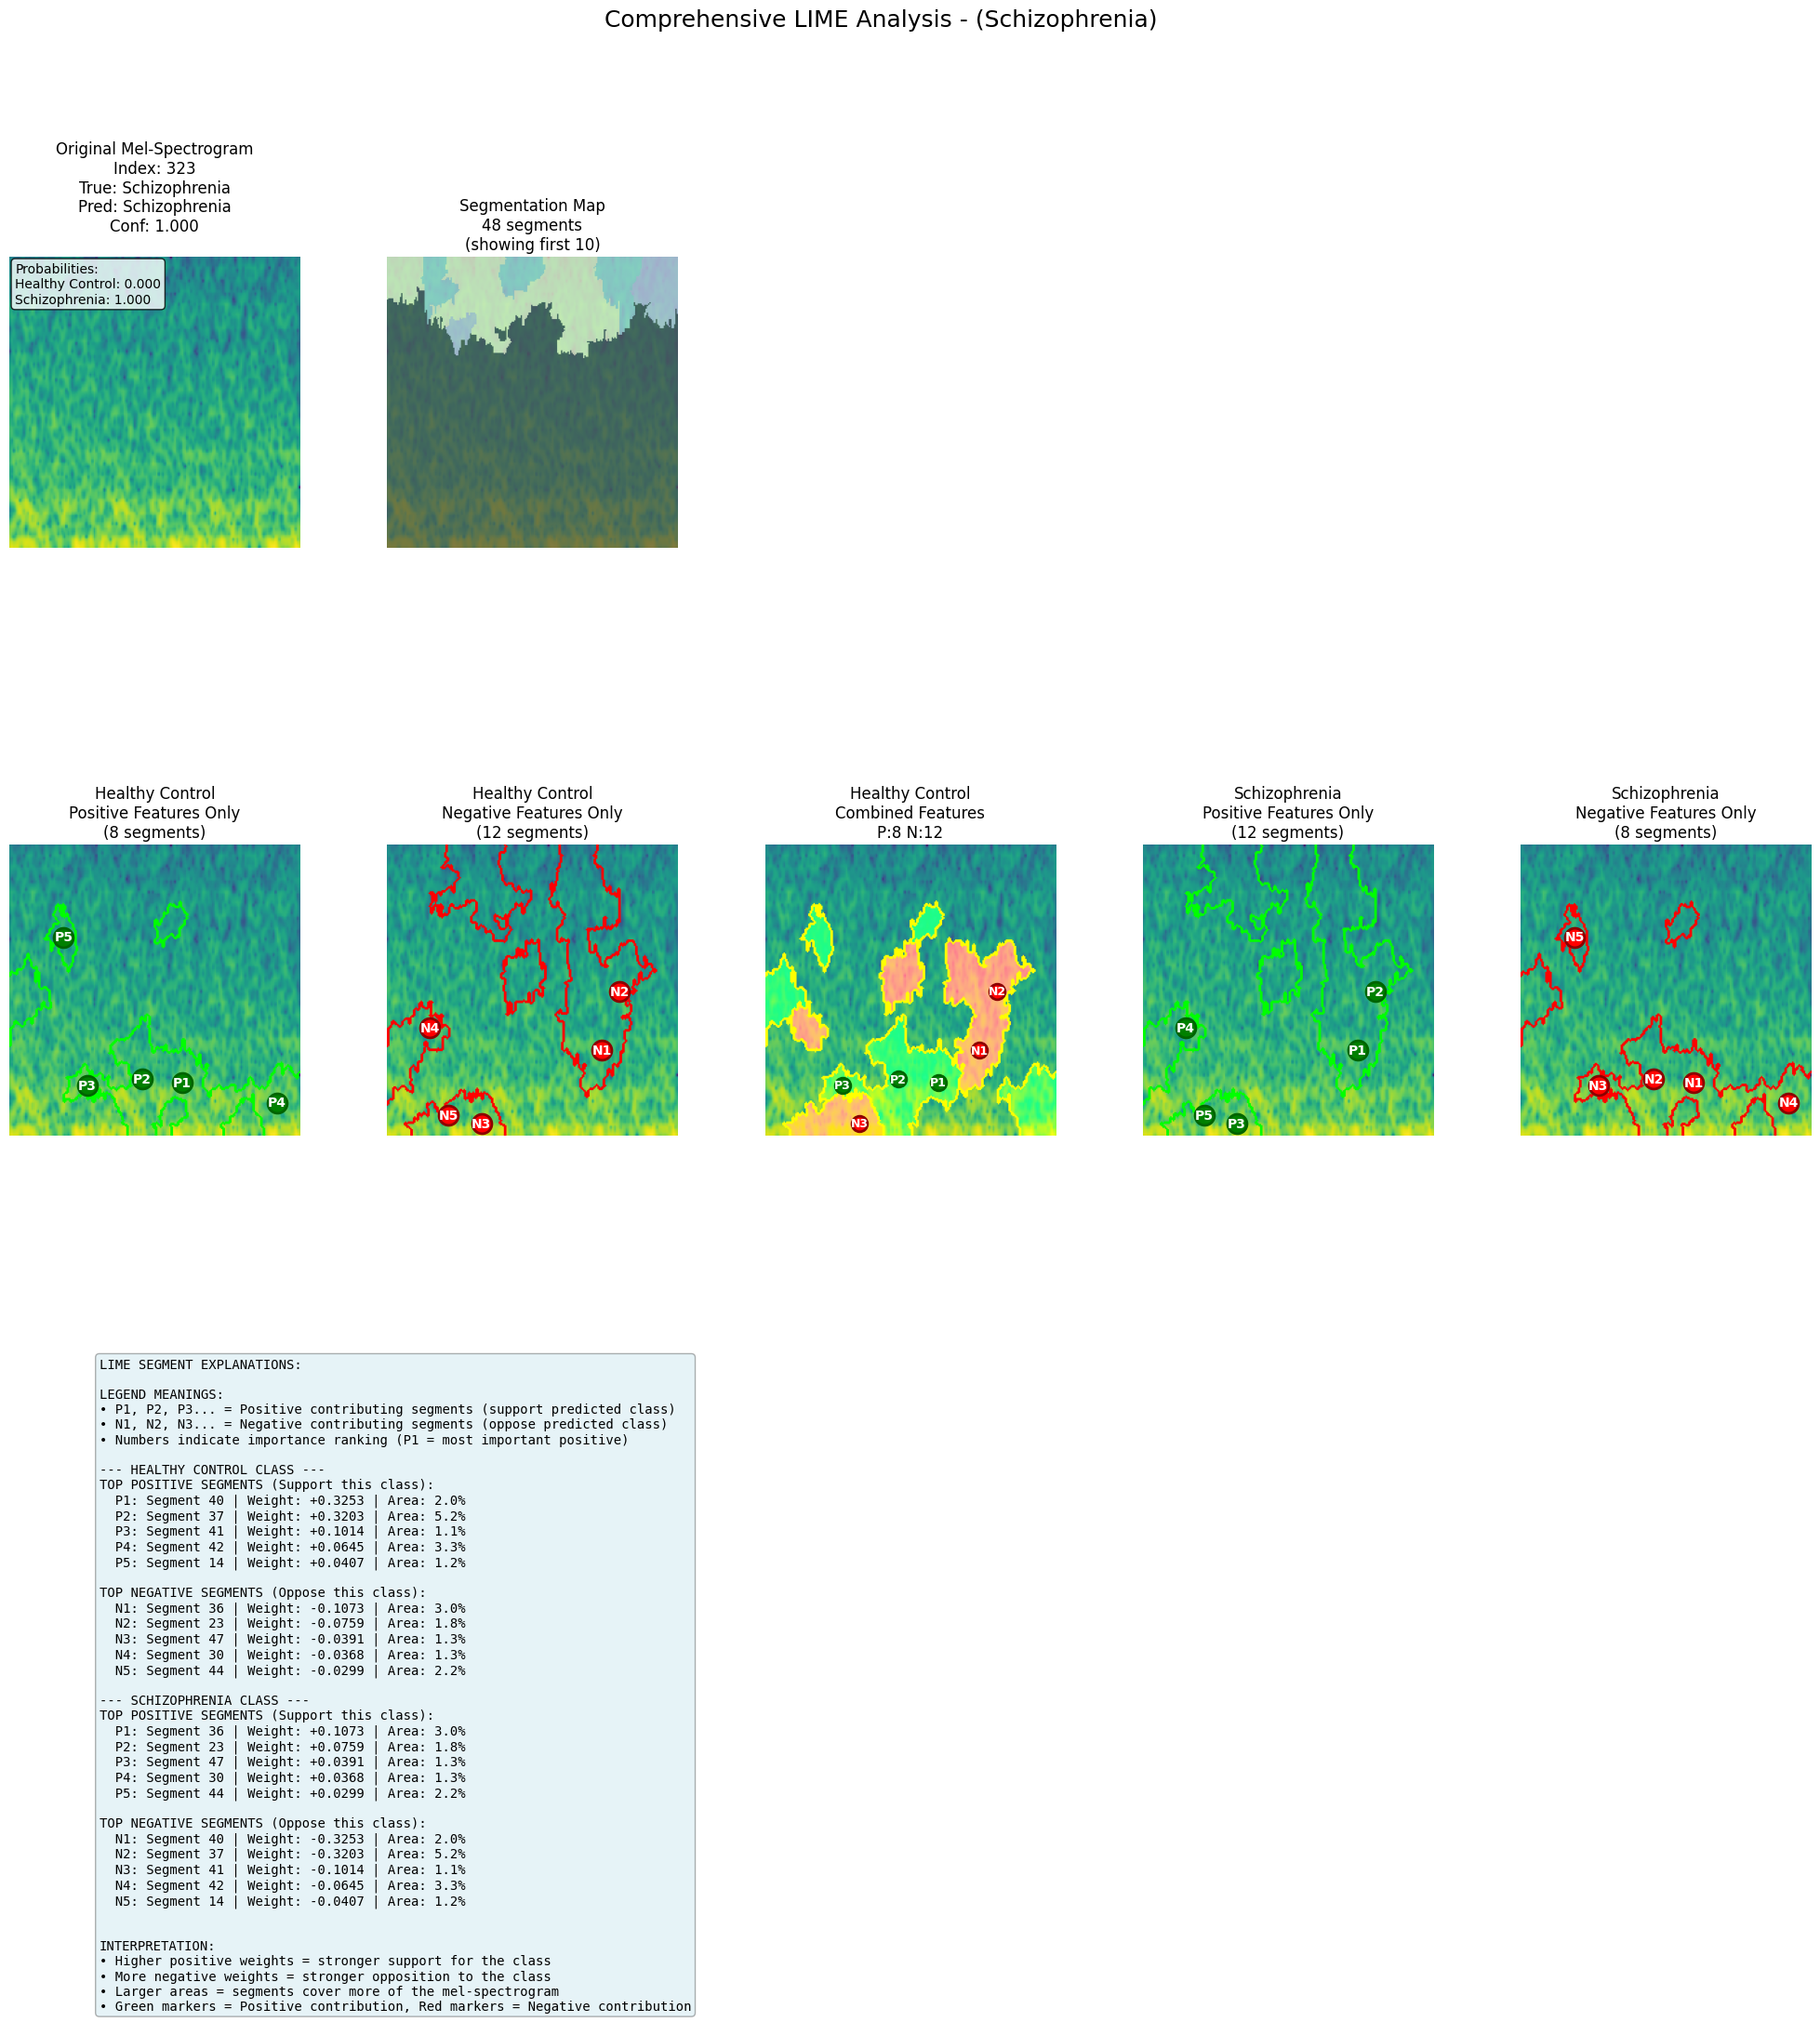


COMPREHENSIVE LIME SEGMENT ANALYSIS
Total segments identified: 48
Image dimensions: (224, 224, 3)
Total pixels analyzed: 50176

----------------------------------------------------------------------
CLASS: SCHIZOPHRENIA
----------------------------------------------------------------------

🟢 POSITIVE CONTRIBUTING SEGMENTS: 8
   (These segments SUPPORT classification as this class)
Rank   Label    Segment ID   Weight       Area %     Interpretation
----------------------------------------------------------------------
P1     P1       40           0.3253       2.0        Very Strong
P2     P2       37           0.3203       5.2        Very Strong
P3     P3       41           0.1014       1.1        Very Strong
P4     P4       42           0.0645       3.3        Strong
P5     P5       14           0.0407       1.2        Moderate

🔴 NEGATIVE CONTRIBUTING SEGMENTS: 12
   (These segments OPPOSE classification as this class)
Rank   Label    Segment ID   Weight       Area %     Interpretat

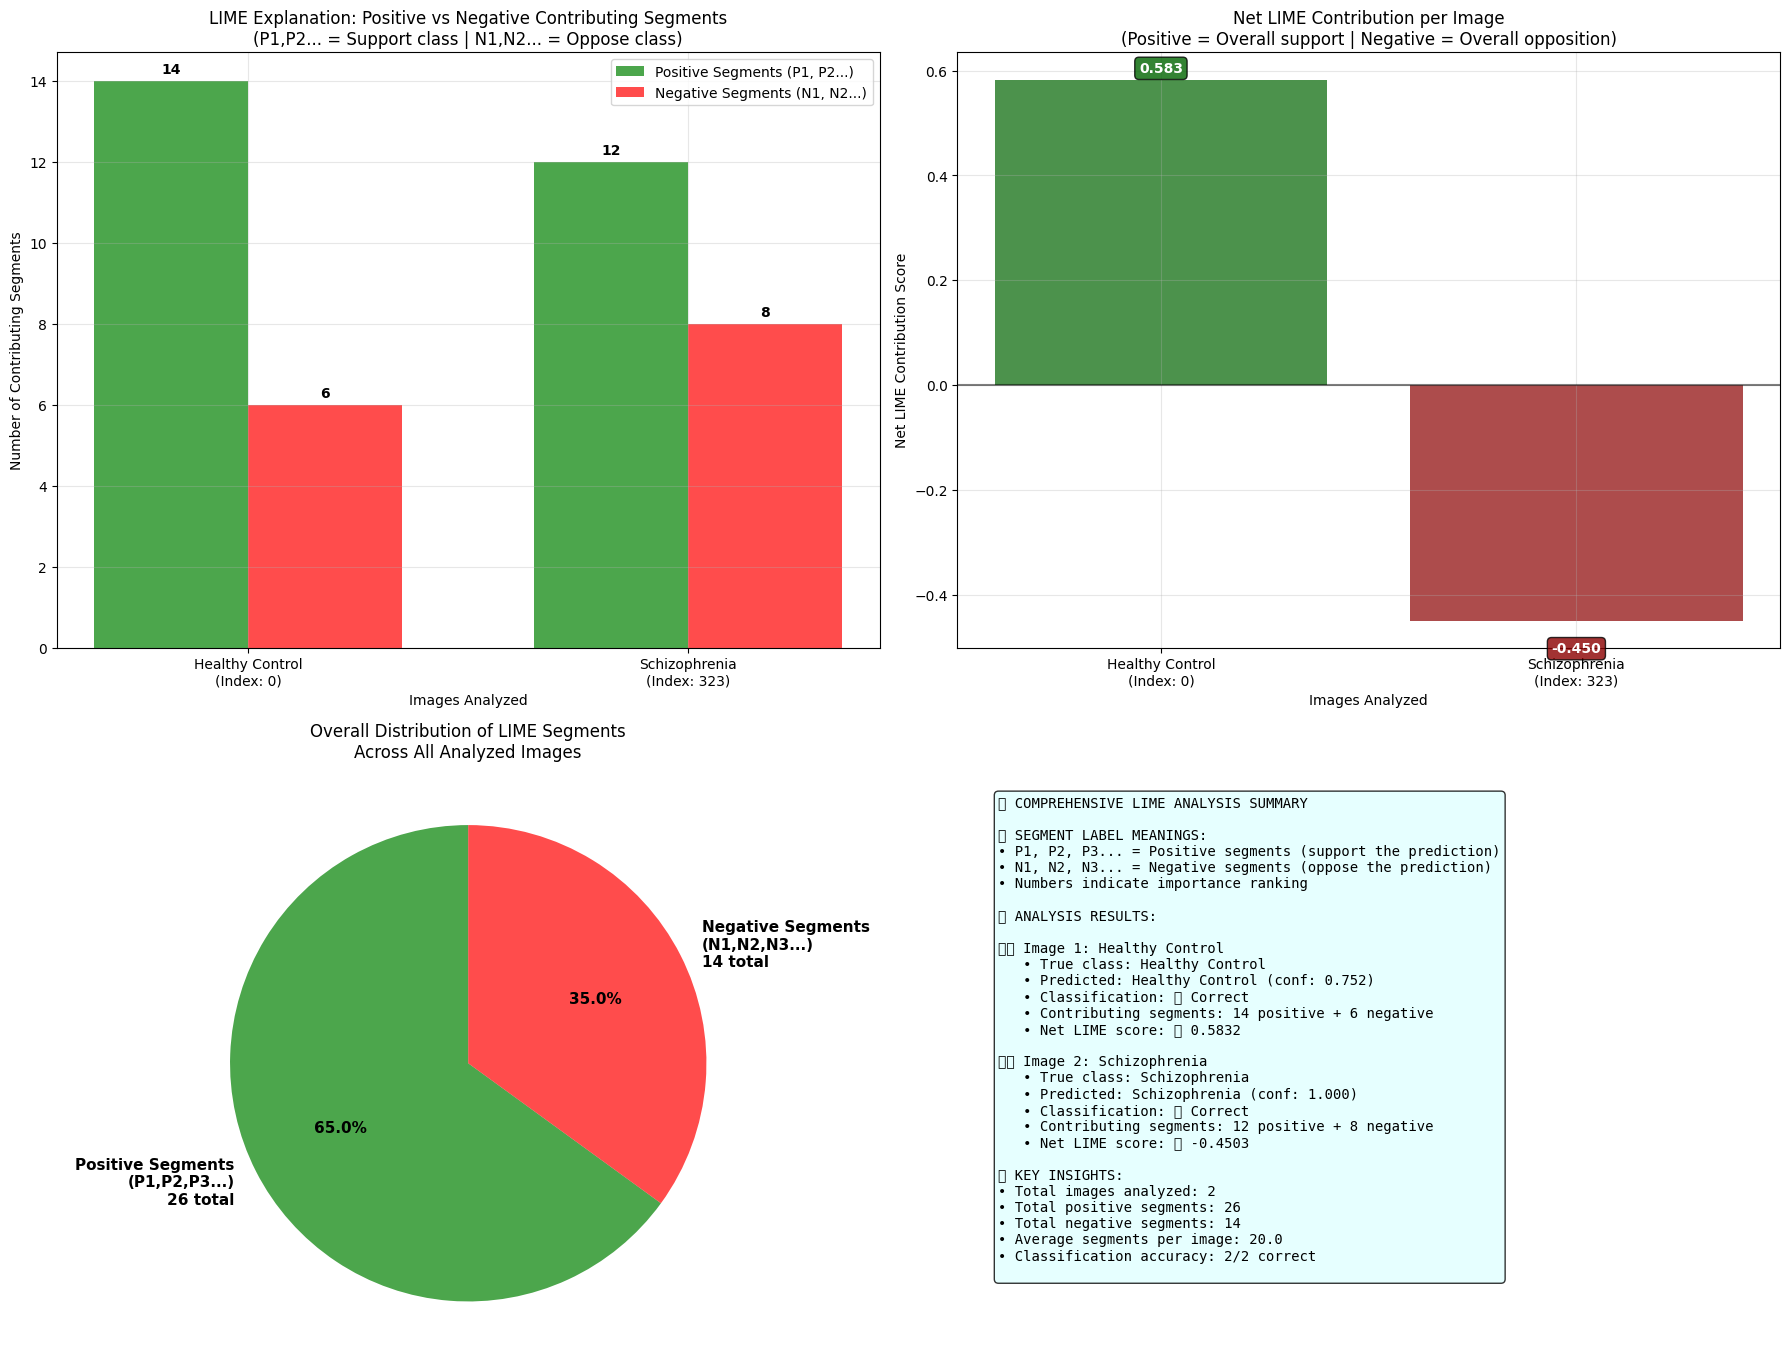


ANALYSIS COMPLETE - FOLD 1
Model Performance:
  • Accuracy: 0.7638
  • Loss: 0.6273
  • Total test samples: 762

LIME Analysis Summary:
  Image 1 (Healthy Control):
    - Classification: Correct
    - Confidence: 0.752
    - Contributing segments: 14 positive, 6 negative
    - Net LIME contribution: 0.5832
  Image 2 (Schizophrenia):
    - Classification: Correct
    - Confidence: 1.000
    - Contributing segments: 12 positive, 8 negative
    - Net LIME contribution: -0.4503

Program completed successfully after Fold 1.
LIME analysis provides detailed explainability for mel-spectrogram based schizophrenia classification.


47281

In [ ]:
# Cell 5: Main Training and Analysis Loop (Fold 1 Only)
acc_per_fold = []
loss_per_fold = []
lime_explanations_data = []

class_names = ['Healthy Control', 'Schizophrenia']

# ONLY FOLD 1 - Code will end after this fold
fold_no = 1

tf.keras.backend.clear_session()
import gc
gc.collect()

train = pd.read_csv(f"D:/Milon2/SD_81/D3_19/LIME/par/train/train{fold_no}.csv", sep=',', header=None)
test = pd.read_csv(f"D:/Milon2/SD_81/D3_19/LIME/par/test/test{fold_no}.csv", sep=',', header=None)

x_train = X[train[0]]
y_train = y[train[0]]
x_test = X[test[0]]
y_test = y[test[0]]

y_train_cat = np_utils.to_categorical(y_train, num_classes)
y_test_cat = np_utils.to_categorical(y_test, num_classes)

print(f"Fold {fold_no} - Training data shape: {x_train.shape}")
print(f"Fold {fold_no} - Test data shape: {x_test.shape}")

# Model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(f'Training for fold {fold_no}...')

filepath = f"D:/Milon2/SD_81/D3_19/LIME/par/a/a{fold_no}.best.keras"

earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=150, mode='auto')
checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True, monitor='val_accuracy')
callbacks_list = [earlystop, checkpointer]

history = model.fit(x_train, y_train_cat, epochs=100, batch_size=32,
                   validation_data=(x_test, y_test_cat), callbacks=callbacks_list)

del x_train, y_train_cat
gc.collect()

model = load_model(filepath)

scores = model.evaluate(x_test, y_test_cat, verbose=0)
print(f'Fold {fold_no} - Loss: {scores[0]:.4f}, Accuracy: {scores[1]*100:.2f}%')
acc_per_fold.append(scores[1] * 100)
loss_per_fold.append(scores[0])

Y_pred = model.predict(x_test, batch_size=16, verbose=0)
y_pred = np.argmax(Y_pred, axis=1)

# Simple accuracy only
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

print('\nConfusion Matrix')
confusion = confusion_matrix(y_test, y_pred)
print(confusion)
print('\nClassification Report')
print(classification_report(y_test, y_pred, target_names=class_names))

del Y_pred
gc.collect()

# Visualization
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("Validation Loss")
ax.set_xlabel("Epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylim(0, 1)
plt.show()
plt.close(fig)

ax = plt.subplot()
sns.heatmap(confusion, annot=True, fmt="d", ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title(f'Confusion Matrix - Fold {fold_no}')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.show()
plt.close()

# COMPREHENSIVE LIME ANALYSIS FOR FOLD 1
print(f"\n{'='*100}")
print(f"COMPREHENSIVE LIME ANALYSIS FOR SCHIZOPHRENIA CLASSIFICATION")
print(f"FOLD {fold_no} - MEL-SPECTROGRAM EXPLAINABILITY")
print(f"{'='*100}")

# Find indices for both classes (first occurrence of each)
healthy_indices = np.where(y_test == 0)[0]
schizo_indices = np.where(y_test == 1)[0]

# Analyze first image of each class
images_to_analyze = []
if len(healthy_indices) > 0:
    images_to_analyze.append(('Healthy Control', healthy_indices[0], 0))
if len(schizo_indices) > 0:
    images_to_analyze.append(('Schizophrenia', schizo_indices[0], 1))

for class_type, img_idx, class_label in images_to_analyze:
    print(f"\n{'='*80}")
    print(f"DETAILED LIME ANALYSIS: {class_type.upper()}")
    print(f"Test Index: {img_idx}, Class Label: {class_label}")
    print(f"{'='*80}")

    sample_image = x_test[img_idx:img_idx+1]
    true_label = y_test[img_idx]
    pred_probs = model.predict(sample_image, batch_size=1, verbose=0)[0]
    pred_label = np.argmax(pred_probs)

    print(f"\nImage Classification Results:")
    print(f"  • True Label: {class_names[true_label]}")
    print(f"  • Predicted Label: {class_names[pred_label]}")
    print(f"  • Prediction Confidence: {pred_probs[pred_label]:.4f}")
    print(f"  • Classification: {'✓ CORRECT' if true_label == pred_label else '✗ INCORRECT'}")
    print(f"  • Class Probabilities:")
    for i, class_name in enumerate(class_names):
        print(f"    - {class_name}: {pred_probs[i]:.4f}")

    # Generate comprehensive LIME explanation
    try:
        lime_fig, lime_explanation = visualize_detailed_lime_explanation(
            model, sample_image, class_names, img_idx, true_label, pred_label, pred_probs
        )

        if lime_fig is not None:
            lime_fig.suptitle(f'Comprehensive LIME Analysis - ({class_type})',
                            fontsize=18, y=0.98)
            plt.show()
            plt.close(lime_fig)

            # Detailed segment analysis
            analyze_lime_segments(lime_explanation, class_names, lime_explanation.segments, sample_image[0])

            # Store data for summary
            class_explanation = lime_explanation.local_exp[lime_explanation.top_labels[class_label]]
            positive_features = [f for f in class_explanation if f[1] > 0]
            negative_features = [f for f in class_explanation if f[1] < 0]

            lime_explanations_data.append({
                'class_name': class_type,
                'index': img_idx,
                'true_class': class_names[true_label],
                'pred_class': class_names[pred_label],
                'confidence': pred_probs[pred_label],
                'correct': true_label == pred_label,
                'positive_count': len(positive_features),
                'negative_count': len(negative_features),
                'net_contribution': sum(f[1] for f in positive_features) + sum(f[1] for f in negative_features)
            })

    except Exception as e:
        print(f"Error in LIME analysis for {class_type}: {e}")
        import traceback
        traceback.print_exc()

# Create summary comparison
if len(lime_explanations_data) > 1:
    print(f"\n{'='*80}")
    print(f"COMPARATIVE LIME ANALYSIS SUMMARY")
    print(f"{'='*80}")

    summary_fig = create_lime_summary_visualization(lime_explanations_data, class_names)

    plt.show()
    plt.close(summary_fig)

# Final Summary
print(f"\n{'='*100}")
print(f"ANALYSIS COMPLETE - FOLD {fold_no}")
print(f"{'='*100}")
print(f"Model Performance:")
print(f"  • Accuracy: {accuracy:.4f}")
print(f"  • Loss: {scores[0]:.4f}")
print(f"  • Total test samples: {len(y_test)}")

if lime_explanations_data:
    print(f"\nLIME Analysis Summary:")
    for i, data in enumerate(lime_explanations_data):
        print(f"  Image {i+1} ({data['class_name']}):")
        print(f"    - Classification: {'Correct' if data['correct'] else 'Incorrect'}")
        print(f"    - Confidence: {data['confidence']:.3f}")
        print(f"    - Contributing segments: {data['positive_count']} positive, {data['negative_count']} negative")
        print(f"    - Net LIME contribution: {data['net_contribution']:.4f}")

print(f"\nProgram completed successfully after Fold {fold_no}.")
print("LIME analysis provides detailed explainability for mel-spectrogram based schizophrenia classification.")

# Clean up memory
del model, x_test, y_test, y_test_cat
gc.collect()